# Libraries

In [1]:
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
import sklearn.svm
import IPython.display as ipd
import scipy as sp

# Feature Computation

In [2]:
# We are going to define three steps for the computation:
# - Apply the mel filters on the windowed spectrum of the signal
# - Take the logarithm scale of the results
# - Apply the Discrete Cosine Transform

def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal
    X = np.abs(librosa.stft( # Short Time Fourier Transform on the windowed signal
        audio,
        window='hamming', # Windowing
        n_fft=1024,
        hop_length=512,)
        )
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr=fs,
        n_fft=1024,
        n_mels=40,
        fmin=133.33,
        fmax=6853.8,
    )
    
    # Apply the filters to spectrogram with dot product
    melspectrogram = np.dot(mel, X)
    # Take the logarithm
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc+1]
    return mfcc

## Computing the Training Features

### Training & Test Definition

In [3]:
classes = ['blues', 'hiphop', 'metal', 'reggae']

n_mfcc = 13 # number of mel filter coefficients
dict_train_features = {'blues': [], 'hiphop': [], 'metal': [], 'reggae': []}

# We are analysing 70 tracks for each genre in this training step
for c in classes:
    train_root = 'D:/ProgettiProgrammazione/CMLS/GTZAN/Input_Audio_Files/{}/training/'.format(c) #Directory Zack
    #train_root = 'Input_Audio_Files/{}/training/'.format(c)
    class_train_files = [f for f in os.listdir(train_root) if f.endswith('.wav')]
    n_train_samples = len(class_train_files)
    
    train_features = np.zeros((n_train_samples, n_mfcc))
    for index, f in enumerate(class_train_files):
        audio, fs = librosa.load(os.path.join(train_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        train_features[index, :] = np.mean(mfcc, axis=1)
        
    dict_train_features[c] = train_features

In [4]:
dict_test_features = {'blues': [], 'hiphop': [], 'metal': [], 'reggae': []}

for c in classes:
    test_root = 'D:/ProgettiProgrammazione/CMLS/GTZAN/Input_Audio_Files/{}/test/'.format(c)
    class_test_files = [f for f in os.listdir(test_root) if f.endswith('.wav')]
    n_test_samples = len(class_test_files)
    
    test_features = np.zeros((n_test_samples, n_mfcc))
    for index, f in enumerate(class_test_files):
        audio, fs = librosa.load(os.path.join(test_root, f), sr=None)
        mfcc = compute_mfcc(audio, fs, n_mfcc)
        test_features[index, :] = np.mean(mfcc, axis=1)
    dict_test_features[c] = test_features

In [5]:
# load the last WAV file in order to check if it correctly upload the training files (there should be a reggae track)
ipd.Audio(audio, rate=fs) 

## Features Visualisation

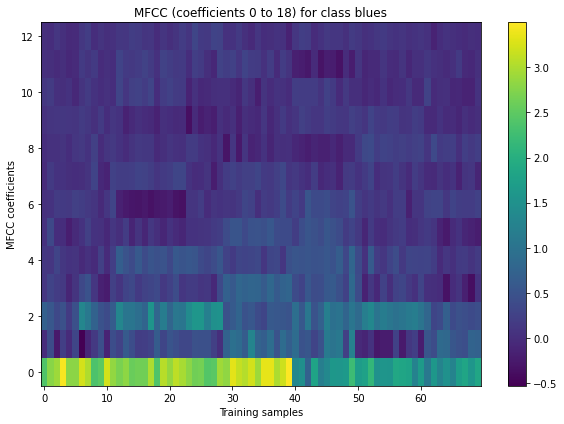

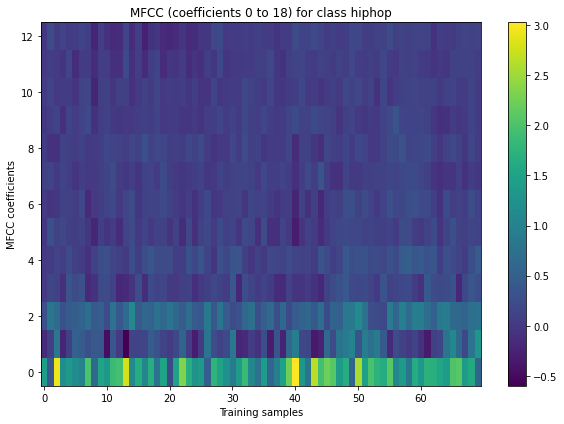

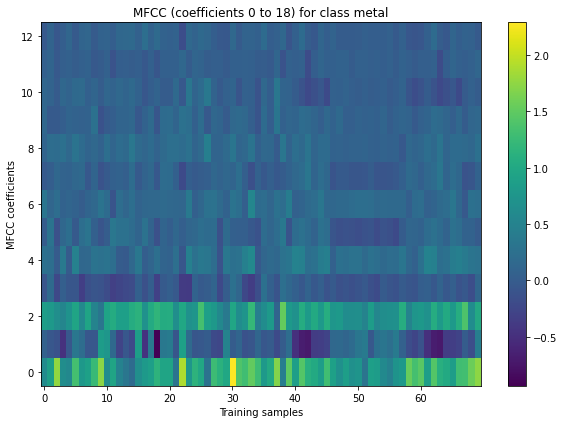

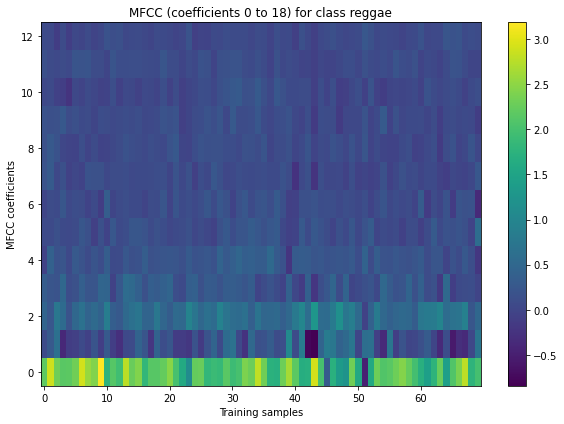

In [6]:
# We are going to visualise the MFCC coefficients matrix for each genre

for c in classes:
    mfcc = dict_train_features[c].transpose()
    # Features Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 18) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

# SVM Classification

In [7]:
class_0 = 'blues'
class_1 = 'hiphop'
class_2 = 'metal'
class_3 = 'reggae'

# Train step
X_train_0 = dict_train_features[class_0]
X_train_1 = dict_train_features[class_1]
X_train_2 = dict_train_features[class_2]
X_train_3 = dict_train_features[class_3]

y_train_0 = np.zeros((X_train_0.shape[0],))
y_train_1 = np.ones((X_train_1.shape[0],))
y_train_2 = np.ones((X_train_2.shape[0],))*2
y_train_3 = np.ones((X_train_3.shape[0],))*3


In [8]:
# Test step
X_test_0 = dict_test_features[class_0]
X_test_1 = dict_test_features[class_1]
X_test_2 = dict_test_features[class_2]
X_test_3 = dict_test_features[class_3]


y_test_0 = np.zeros((X_test_0.shape[0],))
y_test_1 = np.ones((X_test_1.shape[0],))
y_test_2 = np.ones((X_test_2.shape[0],))*2
y_test_3 = np.ones((X_test_3.shape[0],))*3

y_test_mc = np.concatenate((y_test_0, y_test_1, y_test_2, y_test_3), axis=0)

### Features Normalisation

In [9]:
feat_max = np.max(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)
feat_min = np.min(np.concatenate((X_train_0, X_train_1, X_train_2), axis=0), axis=0)

X_train_0_normalized = (X_train_0 - feat_min) / (feat_max - feat_min)
X_train_1_normalized = (X_train_1 - feat_min) / (feat_max - feat_min)
X_train_2_normalized = (X_train_2 - feat_min) / (feat_max - feat_min)
X_train_3_normalized = (X_train_3 - feat_min) / (feat_max - feat_min)

X_test_0_normalized = (X_test_0 - feat_min) / (feat_max - feat_min)
X_test_1_normalized = (X_test_1 - feat_min) / (feat_max - feat_min)
X_test_2_normalized = (X_test_2 - feat_min) / (feat_max - feat_min)
X_test_3_normalized = (X_test_3 - feat_min) / (feat_max - feat_min)

X_test_mc_normalized = np.concatenate((X_test_0_normalized, X_test_1_normalized, X_test_2_normalized, X_test_3_normalized), axis=0)


## SVM

In [10]:
SVM_parameters={
    'C': 1,
    'kernel': 'rbf',
}

clf_01 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_02 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_03 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_12 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_13 = sklearn.svm.SVC(**SVM_parameters, probability=True)
clf_23 = sklearn.svm.SVC(**SVM_parameters, probability=True)

In [11]:
clf_01.fit(np.concatenate((X_train_0_normalized, X_train_1_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_1), axis=0))
           
clf_02.fit(np.concatenate((X_train_0_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_2), axis=0))

clf_03.fit(np.concatenate((X_train_0_normalized, X_train_3_normalized), axis=0), 
           np.concatenate((y_train_0, y_train_3), axis=0))

clf_12.fit(np.concatenate((X_train_1_normalized, X_train_2_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_2), axis=0))

clf_13.fit(np.concatenate((X_train_1_normalized, X_train_3_normalized), axis=0), 
           np.concatenate((y_train_1, y_train_3), axis=0))

clf_23.fit(np.concatenate((X_train_2_normalized, X_train_3_normalized), axis=0), 
           np.concatenate((y_train_2, y_train_3), axis=0))

SVC(C=1, probability=True)

## Evaluate each classifier

In [12]:
y_test_predicted_01 = clf_01.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_02 = clf_02.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_03 = clf_03.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_12 = clf_12.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_13 = clf_13.predict(X_test_mc_normalized).reshape(-1, 1)
y_test_predicted_23 = clf_23.predict(X_test_mc_normalized).reshape(-1, 1)

### Majority voting

In [13]:
y_test_predicted_mc = np.concatenate((y_test_predicted_01, y_test_predicted_02, y_test_predicted_03, y_test_predicted_12,y_test_predicted_13,y_test_predicted_23), axis=1)
y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)

<ipython-input-13-26c20ee665f9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_test_predicted_mc = np.array(y_test_predicted_mc, dtype=np.int)


In [14]:
y_test_predicted_mv = np.zeros((y_test_predicted_mc.shape[0],))
for i, e in enumerate(y_test_predicted_mc):
    y_test_predicted_mv[i] = np.bincount(e).argmax() 

In [15]:

def compute_cm_multiclass(gt, predicted):
    classes = np.unique(gt)
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    print(CM)

In [16]:
compute_cm_multiclass(y_test_mc, y_test_predicted_mv)

[[14.  5.  0. 11.]
 [ 1. 21.  2.  6.]
 [ 3.  9. 16.  2.]
 [ 3. 16.  4.  7.]]
